In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
# !bash report.sh
organisms = set(pandas.read_csv("biomass_constrained.txt",index_col=0,header=None).index.to_list())
done = {i.split(".csv")[0] for i in os.listdir("./cases/fluxes/low_zinc/")}

In [4]:
len(organisms)

495

### Load

In [5]:
growth = pandas.read_csv("datasets/all_growth_rates.csv",index_col=0)
growth = growth.drop("mid_zinc",axis=1)

In [8]:
for c in growth.columns:
    print(c,growth[c].min(),growth[c].max())

base 0.0017224918196842 0.6792252213820068
low_iron 1.6984775971397423e-05 0.4632722425543222
low_zinc 0.0023632604855525 0.6782056476949729
high_FA 0.001739241059471 0.6792252213820068
high_carbs 0.0017224918196842 1.943201242143248
high_prot 0.0024011710158491 0.8852455605479459
micro_oxygen 0.0012863416156334 0.7007620638695867


In [6]:
# growth.drop("low_zinc",axis=1,inplace=True)

In [7]:
# abundance = (growth / growth.sum())
abundance = (growth.div(growth["base"],axis=0))

### By taxa

In [8]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]
# taxa = "Family"
# taxa_list = ["Phylum","Class","Order","Family"]
taxa_list = ["Phylum","Class","Order","Family","Genus","Species","Strain"]
taxa = taxa_list[-1]
# abundance[taxa] = taxonomy[taxa]
# taxa_abundance = abundance.groupby(taxa).sum()
taxonomy.head()

,NCBI Taxonomy ID,Strain,Species,Genus,Family,Order,Class,Phylum,Kingdom
MicrobeID,,,,,,,,,
Abiotrophia_defectiva_ATCC_49176,592010,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva,Abiotrophia,Aerococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
Acidaminococcus_fermentans_DSM_20731,591001,Acidaminococcus fermentans DSM 20731,Acidaminococcus fermentans,Acidaminococcus,Acidaminococcaceae,Acidaminococcales,Negativicutes,Firmicutes,Bacteria
Acidaminococcus_intestini_RyC_MR95,568816,Acidaminococcus intestini RyC-MR95,Acidaminococcus intestini,Acidaminococcus,Acidaminococcaceae,Acidaminococcales,Negativicutes,Firmicutes,Bacteria
Acidaminococcus_sp_D21,904,Acidaminococcus,Acidaminococcus sp. D21,Acidaminococcus,Acidaminococcaceae,Acidaminococcales,Negativicutes,Firmicutes,Bacteria
Acinetobacter_calcoaceticus_PHEA_2,871585,Acinetobacter pittii PHEA-2,Acinetobacter pittii,Acinetobacter,Moraxellaceae,Moraxellales,Gammaproteobacteria,Proteobacteria,Bacteria


In [9]:
taxa_abundance = pandas.concat([abundance,taxonomy],axis=1)
taxa_abundance = taxa_abundance.groupby(taxa_list).sum()
taxa_abundance = taxa_abundance[[i for i in taxa_abundance.columns if i not in taxonomy.columns]]

## Mean and sum give the same zscores
# taxa_abundance = taxa_abundance.groupby(taxa_list).mean().drop("NCBI Taxonomy ID",axis=1)
taxa_abundance.head()

/tmp/ipykernel_941925/432459178.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  taxa_abundance = taxa_abundance.groupby(taxa_list).sum()


base  \
Phylum         Class         Order           Family           Genus           Species                      Strain                                         
Actinobacteria Actinomycetia Actinomycetales Actinomycetaceae Actinomyces     Actinomyces graevenitzii     Actinomyces graevenitzii C83             1.0   
                                                                              Actinomyces urogenitalis     Actinomyces urogenitalis DSM 15434       1.0   
                                                                              Actinomyces viscosus         Actinomyces viscosus C505                1.0   
                                                              Arcanobacterium Arcanobacterium haemolyticum Arcanobacterium haemolyticum DSM 20595   1.0   
                                                              Mobiluncus      Mobiluncus curtisii          Mobiluncus curtisii ATCC 43063           1.0   

                                                                                                                                                   low_iron  \
Phylum         Class         Order           Family           Genus           Species                      Strain                                             
Actinobacteria Actinomycetia Actinomycetales Actinomycetaceae Actinomyces     Actinomyces graevenitzii     Actinomyces graevenitzii C83            0.187309   
                                                                              Actinomyces urogenitalis     Actinomyces urogenitalis DSM 15434      0.999985   
                                                                              Actinomyces viscosus         Actinomyces viscosus C505               0.921673   
                                                              Arcanobacterium Arcanobacterium haemolyticum Arcanobacterium haemolyticum DSM 20595  0.197098   
                                                              Mobiluncus      Mobiluncus curtisii          Mobiluncus curtisii ATCC 43063          0.113850   

                                                                                                                                                   low_zinc  \
Phylum         Class         Order           Family           Genus           Species                      Strain                                             
Actinobacteria Actinomycetia Actinomycetales Actinomycetaceae Actinomyces     Actinomyces graevenitzii     Actinomyces graevenitzii C83                 0.0   
                                                                              Actinomyces urogenitalis     Actinomyces urogenitalis DSM 15434           0.0   
                                                                              Actinomyces viscosus         Actinomyces viscosus C505                    0.0   
                                                              Arcanobacterium Arcanobacterium haemolyticum Arcanobacterium haemolyticum DSM 20595       0.0   
                                                              Mobiluncus      Mobiluncus curtisii          Mobiluncus curtisii ATCC 43063               0.0   

                                                                                                                                                   high_FA  \
Phylum         Class         Order           Family           Genus           Species                      Strain                                            
Actinobacteria Actinomycetia Actinomycetales Actinomycetaceae Actinomyces     Actinomyces graevenitzii     Actinomyces graevenitzii C83                1.0   
                                                                              Actinomyces urogenitalis     Actinomyces urogenitalis DSM 15434          1.0   
                                                                              Actinomyces viscosus         Actinomyces viscosus C505                   1.0   
                                           

### Plot clustergram

In [10]:
from scipy.stats import zscore
tmp = taxa_abundance.copy().reset_index().set_index(taxa_list[-1])
tmp = tmp[[i for i in tmp.columns if i not in taxonomy.columns]]
# tmp = tmp.apply(zscore,axis=0)
# tmp = tmp.subtract(tmp["base"],axis=0)
tmp = tmp.drop("base",axis=1)

/tmp/ipykernel_941925/1782582139.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


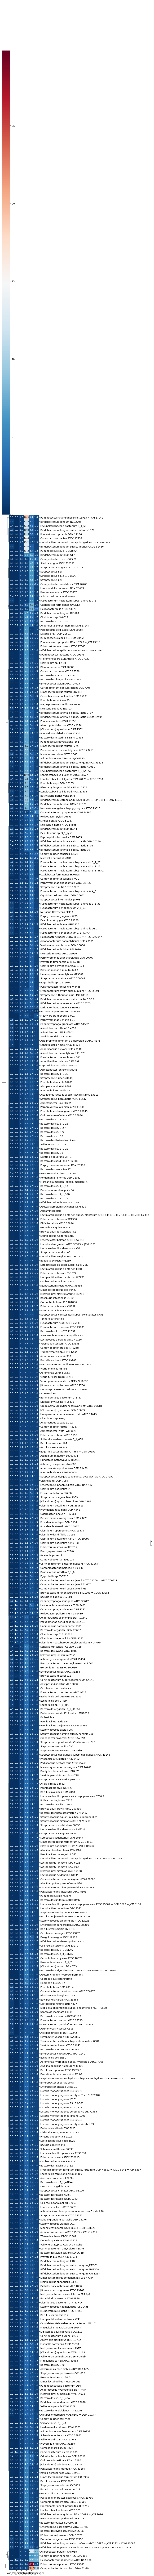

In [11]:
import seaborn as sns
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_bad('midnightblue')      # color of mask on heatmap
cmap.set_under('white')
cmap = sns.clustermap(tmp,
               # row_cluster=False,
               col_cluster=False,
               # vmin=tmp[tmp>0].min().min(),
               # vmax=tmp[tmp>0].max().max(),
               annot=True,
               fmt=".1f",
               cmap=cmap,
               figsize=(1.5*tmp.shape[1],(0.3)*tmp.shape[0]),
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# plt.setp(cmap.ax_heatmap.get_yticklabels(), rotation=0)
# plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

# plt.savefig("./figures/diets_growth_rate_clustermap.svg",format="SVG")

### Save dataset for enrichment analysis

In [12]:
taxa_tmp = taxa_abundance.reset_index()
taxa_tmp = taxa_tmp[[i for i in taxa_tmp.columns if i in taxonomy.columns]]
taxa_tmp = taxa_tmp.set_index(taxa_list[-1])

In [13]:
tmp = pandas.concat([tmp,taxa_tmp],axis=1)
tmp.head(3)

,low_iron,low_zinc,high_FA,high_carbs,high_prot,micro_oxygen,Phylum,Class,Order,Family,Genus,Species
Strain,,,,,,,,,,,,
Actinomyces graevenitzii C83,0.187309,0.0,1.0,1.000000,1.490844,1.155304,Actinobacteria,Actinomycetia,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces graevenitzii
Actinomyces urogenitalis DSM 15434,0.999985,0.0,1.0,4.356212,1.582285,1.090840,Actinobacteria,Actinomycetia,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces urogenitalis
Actinomyces viscosus C505,0.921673,0.0,1.0,2.013952,1.743057,1.131583,Actinobacteria,Actinomycetia,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces viscosus


In [14]:
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
tmp.loc[labels].to_csv("./datasets/2.3.1.all_growth_rates_fold_change_{}.csv".format(taxa_list[-1]))

## Iron

### Increase
Iron repletion decreases Bifidobacteria: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7400826/

Bifidobacteria are resistant to iron deficiency: https://bmcmicrobiol.biomedcentral.com/articles/10.1186/s12866-014-0334-z

Moraxella catarrhalis becomes invasive in iron defficiency:https://academic.oup.com/labmed/article/38/7/420/2504625

Fusobacterium is boosted by iron deficiency https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9675438/

Desulfovibrio is not affected by iron def https://onlinelibrary.wiley.com/doi/pdfdirect/10.1002/mbo3.213

### Decrease

Enterobactericeae, lactobacillus decrease with iron def: https://www.sciencedirect.com/science/article/pii/S0955286318306065#f0010

Iron deficiency reduces the pathogen Brucellaceae https://link.springer.com/article/10.1007/s12275-010-0145-3